# CNN with filtered + fft images

In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import statistics

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from scipy import signal
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.fft import fftshift

import os
from PIL import Image
from scipy.signal import spectrogram

## Images parameters

In [30]:
images_path = '../raw_data/images'

batch_size = 32
img_height = 128
img_width = 128

## Train and validation sets

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2142 files belonging to 2 classes.
Using 1714 files for training.


In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2142 files belonging to 2 classes.
Using 428 files for validation.


**Make sure class names are correct**

In [33]:
class_names = train_ds.class_names
print(class_names)

['interictal', 'preictal']


## Color normalization

In [34]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# test
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.3571998


In [51]:
first_image

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01099878, 0.01099878, 0.01099878],
        [0.0239277 , 0.0239277 , 0.0239277 ],
        [0.01559436, 0.01559436, 0.01559436],
        ...,
        [0.01550245, 0.01550245, 0.01550245],
        [0.02218137, 0.02218137, 0.02218137],
        [0.0140625 , 0.0140625 , 0.0140625 ]],

       [[0.01099878, 0.01099878, 0.01099878],
        [0.0239277 , 0.0239277 , 0.0239277 ],
        [0.01559436, 0.01559436, 0.01559436],
        ...,
        [0.01550245, 0.01550245, 0.01550245],
        [0.02218137, 0.02218137, 0.02218137],
        [0.0140625 , 0.0140625 , 0.0140625 ]],

       [[0.01099878, 0.01099878, 0.01099878],
        [0.0239277 , 0.0239277 , 0.0239277 ],
        [0.01559436, 0.01559436, 0.01559436],
        ...,
        [0.01550245, 0.01550245, 0.01550245],
        [0.02218137, 0.02218137, 0.02218137],
        [0.0140625 , 0.0140625 , 0.0140625 ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.  

## Model architecture

In [67]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Flatten(),
  layers.Dense(1, activation='sigmoid'),
])

## Compiling + Summary

In [68]:
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
recall = Recall()
precision = Precision()

In [69]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', recall, precision])

In [70]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 16, 16, 32)       

## Fitting + learning curves

In [113]:
class_weight = {0: 1.,
                1: 10}
epochs=20
callback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight,
  callbacks=[callback]
)

Epoch 1/20
54/54 [==============================] - 9s 147ms/step - loss: 0.1045 - accuracy: 0.9621 - recall_8: 0.9573 - precision_7: 0.9247 - val_loss: 0.2513 - val_accuracy: 0.9159 - val_recall_8: 0.8934 - val_precision_7: 0.8258
Epoch 2/20
54/54 [==============================] - 7s 130ms/step - loss: 0.0727 - accuracy: 0.9778 - recall_8: 0.9759 - precision_7: 0.9546 - val_loss: 0.2440 - val_accuracy: 0.9229 - val_recall_8: 0.8770 - val_precision_7: 0.8560
Epoch 3/20
54/54 [==============================] - 7s 130ms/step - loss: 0.0565 - accuracy: 0.9842 - recall_8: 0.9814 - precision_7: 0.9689 - val_loss: 0.2527 - val_accuracy: 0.9136 - val_recall_8: 0.8770 - val_precision_7: 0.8295
Epoch 4/20
54/54 [==============================] - 7s 130ms/step - loss: 0.0484 - accuracy: 0.9825 - recall_8: 0.9833 - precision_7: 0.9619 - val_loss: 0.2588 - val_accuracy: 0.9206 - val_recall_8: 0.8525 - val_precision_7: 0.8667
Epoch 5/20
54/54 [==============================] - 7s 130ms/step - loss

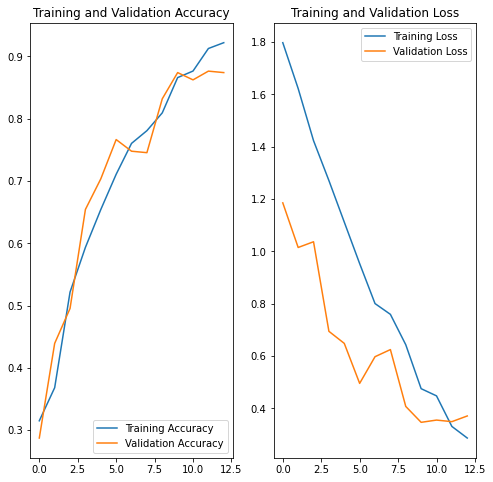

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(13)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(np.arange(13), acc, label='Training Accuracy')
plt.plot(np.arange(13), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.arange(13), loss, label='Training Loss')
plt.plot(np.arange(13), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Tests

In [101]:
segment

,0,1,2,3,4,5,6,7,8,9,...,239756,239757,239758,239759,239760,239761,239762,239763,239764,239765
0,-94,-89,-76,-73,-80,-100,-115,-132,-130,-118,...,20,8,-3,5,21,37,43,42,30,5
1,-47,-35,-25,-19,-18,-30,-35,-29,-30,-36,...,-43,-35,-9,1,0,6,20,12,10,13
2,12,15,13,13,14,19,18,24,27,23,...,-22,-19,-6,4,-1,-14,-21,-25,-29,-26
3,-15,-12,-6,-5,-5,-4,8,18,25,24,...,-17,-18,-11,-4,-6,-19,-29,-28,-6,8
4,-38,-39,-53,-61,-54,-49,-59,-62,-61,-53,...,38,40,29,23,26,30,26,17,13,15
5,-43,-36,-31,-26,-28,-32,-36,-38,-37,-37,...,26,36,28,20,11,4,3,6,11,9
6,-13,-12,-15,-16,-16,-19,-12,-3,-2,-4,...,-6,-9,-7,-6,-12,-16,-27,-30,-27,-21
7,-8,-4,-12,-22,-24,-18,-8,3,5,3,...,-6,-6,2,9,15,8,-6,-11,-8,-4
8,11,-3,-11,-5,1,10,17,11,7,6,...,-10,-19,-26,-35,-33,-18,-2,9,9,4
9,20,9,4,6,13,19,19,11,12,8,...,-6,-12,-18,-20,-16,-11,-4,3,-2,-4


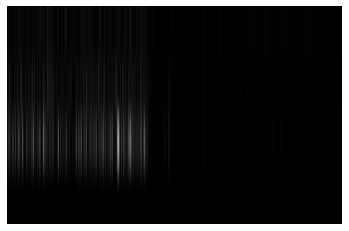

In [102]:
import scipy.io
sos_hp = signal.butter(10, 0.5, 'highpass', fs=400, output='sos')
sos_lp = signal.butter(10, 50, 'lowpass', fs=400, output='sos')

test1 = scipy.io.loadmat("../raw_data/Dog_1/Dog_1/Dog_1_test_segment_0021.mat")
segment_name = list(test1.keys())[-1]
segment = pd.DataFrame(test1[segment_name][0][0][0])
for index, row in segment.iterrows():
    electrode = signal.sosfilt(sos_hp, row)
    electrode_filtered = signal.sosfilt(sos_lp, electrode)
    f, t, Sxx = signal.spectrogram(electrode_filtered, fs=400, nperseg=256)
    plt.imshow(Sxx[f<5,],aspect='auto',origin='lower',cmap='Greys_r')
    plt.axis('off')
    plt.savefig(f'../raw_data/images_test/preictal/test{index}.png', bbox_inches='tight',pad_inches = 0)

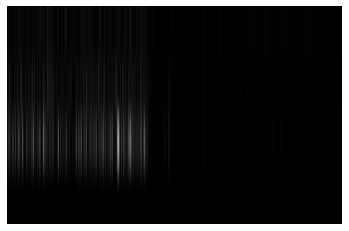

In [103]:
test2 = scipy.io.loadmat("../raw_data/Dog_1/Dog_1/Dog_1_test_segment_0001.mat")
segment_name = list(test1.keys())[-1]
segment = pd.DataFrame(test1[segment_name][0][0][0])
for index, row in segment.iterrows():
    electrode = signal.sosfilt(sos_hp, row)
    electrode_filtered = signal.sosfilt(sos_lp, electrode)
    f, t, Sxx = signal.spectrogram(electrode_filtered, fs=400, nperseg=256)
    plt.imshow(Sxx[f<5,],aspect='auto',origin='lower',cmap='Greys_r')
    plt.axis('off')
    plt.savefig(f'../raw_data/images_test/interictal/test{index}.png', bbox_inches='tight',pad_inches = 0)

In [116]:
images_test_path = '../raw_data/images_test'

In [117]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_test_path,
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 32 files belonging to 2 classes.


In [106]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# test
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.44871327


In [121]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1], dtype=int32)>

In [123]:
y_pred = model.predict(test_ds)

In [131]:
y_pred.round(decimals=0, out=None).astype(int)

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [132]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_batch, y_pred.round(decimals=0, out=None).astype(int))

array([[ 4, 12],
       [ 2, 14]])